In [36]:
import os
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(8,5)})


from sklearn.model_selection import train_test_split
# for nice dark theme in Jupyter Notebooks
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import warnings
warnings.filterwarnings('once')

from time import time
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, make_scorer, mean_squared_error

from src.features.build_features import make_final_train_set
from src.models.utils import report_best_cv_scores, plot_feature_importances
from src.models.utils import plot_max_depth_train_val_scores

In [5]:
%load_ext autoreload
%autoreload 2

In [10]:
column_names, full_pipeline, df_train = make_final_train_set()
X_train = df_train.drop('mpg', axis=1)
y_train = df_train['mpg']

/Users/Corentin/anaconda3/envs/auto-mpg/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Corentin/anaconda3/envs/auto-mpg/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


RandomizedSearchCV is a good alternative for model selection anf hyperparameter tuning. RandomisedSearchCV yields to the same results as GridSearchCV in a fraction of time of what would take GridSearchCV. [[Bergstra-Bengio-2013]](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)


In [11]:
rf = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
param_dist = {'max_depth' : [3, None],
              'max_features': sp_randint(1, X_train.shape[1]+1),
              'min_samples_split': sp_randint(2, 11),
              'bootstrap' : [True, False],
              }
n_iter_search = 100
rf_random_search = RandomizedSearchCV(rf,
                                      param_distributions=param_dist,
                                      n_iter=n_iter_search,
                                      cv=5,
                                      iid=False,
                                      return_train_score=True,
                                      verbose=True,
                                      random_state=42,
                                      n_jobs=-1)

start = time()
rf_random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {:d} candidates'.format(time()-start,
                                                                          n_iter_search))

report_best_cv_scores(rf_random_search.cv_results_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   58.8s


RandomizedSearchCV took 65.24 seconds for 100 candidates
Best model scores
Mean validation score: 0.857 (std: 0.036)
Mean train score: 0.981 (std: 0.001)


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


The best model found by RandomizedSearch seems to overfit the model. One thing we could decrese is the `max_depth` the trees can take.

### Feature importances

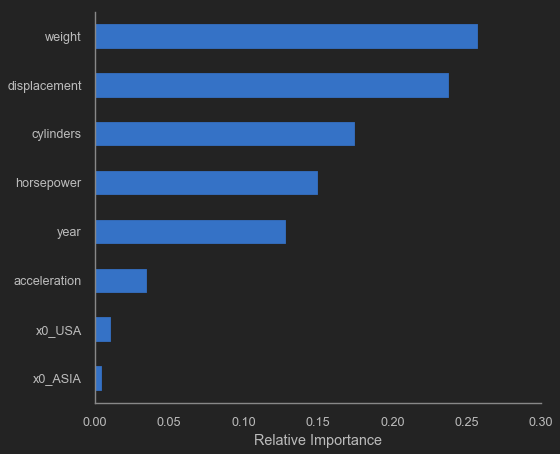

In [30]:
plot_feature_importances(rf_random_search.best_estimator_, X_train)

One Region category is important. We can keep USA category and drop ASIA.

### Reduce overfitting

RandomsSeachCV tries to maxize the validation score without counting for overfitting.
This is way for the best selected model we have a high training score.

One way to reduce overfitting is to limit the depth of the trees.

In this section, we will find the optimal `max_depth` parameter to reduce overfitting.
We'll start from the best hyperparameters found by RandomSearchCV.

In [14]:
rf = RandomForestRegressor(n_estimators=100,
                           bootstrap=True,
                           max_features=3,
                           min_samples_split=2,
                           random_state=42,
                           n_jobs=-1)
max_depths = np.linspace(1, 50, 50, endpoint=True)

params = {'max_depth':max_depths}

rf_cv = GridSearchCV(estimator=rf,
                     param_grid=params,
                     cv=5,
                     n_jobs=-1)  
rf_cv.fit(X_train, y_train)

validation_scores = rf_cv.cv_results_['mean_test_score']
train_scores = rf_cv.cv_results_['mean_train_score']

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

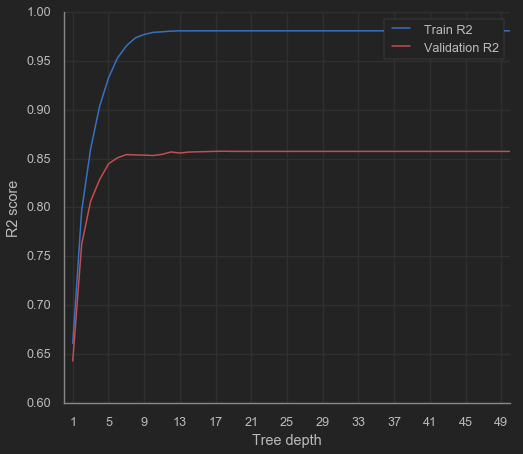

In [34]:
plot_max_depth_train_val_scores(train_scores, validation_scores, max_depths)

For `max_depth` of `5`:
- validation score is about `0.844` 
- training score is about `0.932`.

This is a good compromise to avoid overfitting the training set.

## Model Training 

In [35]:
rf = RandomForestRegressor(max_depth=5,
                           n_estimators=100,
                           bootstrap=True,
                           max_features=3,
                           min_samples_split=2,
                           random_state=42,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)